# Coda Clout — Exploratory Data Analysis (UPGRADED)

Predicting sustained posthumous Wikipedia legacy using pre-death features.

**Upgrades:**
- Better legend labeling (top 15% by sustained ratio)
- Age at death feature
- Cause of death categories
- Pre-death fame proxy
- Log transformations
- Year-based sampling weights


## How I Defined "Legend"

I wanted to identify people who had **sustained posthumous attention**, not just a temporary spike when they died. So I came up with this metric:

```
sustained_ratio_31_365 = avg_views_post_30_365 / avg_views_pre_year
```

Basically:
- **Post-death**: Average daily views from days 30-365 after they died
- **Pre-death**: Average daily views from the year before they died

### Why I did it this way

1. **Skip the first month**: Everyone gets a spike right after death from news coverage. Starting at day 30 filters that out and shows if people are still actually interested months later.

2. **Normalize by baseline**: Someone who was already super famous (like 1000 views/day) needs way more views to be a "legend" than someone who had 10 views/day. The ratio accounts for that.

3. **Sustained = real legacy**: If people are still looking someone up 6-12 months later, that's actual cultural impact, not just news cycle stuff.

### My labeling approach

I tried a few things:
- First tried: `ratio > 2.5` AND `post_30_365_avg_daily > 50` (needed both high ratio AND high volume)
- Problem: Only got like 40 legends, which is too few for modeling
- So I switched to: **just sorted by sustained ratio and took the top 15%**

Basically I calculated the 85th percentile threshold (which came out to 2.75) and marked anyone above that as a legend.
- This gives me 99 legends out of 660 dead people (15%)

I went with top 15% instead of a fixed threshold because the distribution varies a lot. This way I get enough legends to actually train a model while still being selective about who counts.

### Example

Say someone had 10 views/day before death, then 50 views/day in months 1-12 after death:
- Ratio = 50/10 = 5.0 → **LEGEND**

They're getting 5x their normal attention even months later, which is what I'm looking for.


## 1. Imports & Setup


In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Load balanced dataset (equal sampling per year, fixes 2018 bias)
df = pd.read_csv("../setup/modeling_data_balanced.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nLegend distribution:")
print(df['is_legend'].value_counts())
print(f"\nLegend rate: {df['is_legend'].mean():.1%}")
print(f"\nTrain/Val split:")
print(df['split'].value_counts())
print(f"\nYear distribution (balanced):")
print(df['death_year'].value_counts().sort_index())


Dataset shape: (2659, 50)

Legend distribution:
is_legend
0.0    2589
1.0      70
Name: count, dtype: int64

Legend rate: 2.6%

Train/Val split:
split
train    1757
val       902
Name: count, dtype: int64

Year distribution (balanced):
death_year
2017.0    228
2018.0    314
2019.0    308
2020.0    279
2021.0    314
2022.0    314
2023.0    314
2024.0    314
2025.0    274
Name: count, dtype: int64


## 1. Target Distribution


Saved: figures/01_target_distribution.png


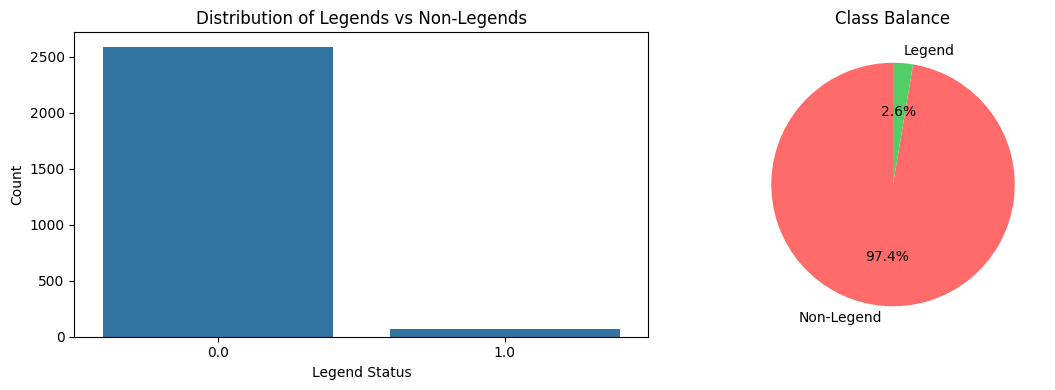

In [53]:
# 1. Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(x='is_legend', data=df, ax=axes[0])
axes[0].set_title("Distribution of Legends vs Non-Legends")
axes[0].set_xlabel("Legend Status")
axes[0].set_ylabel("Count")

# Pie chart
legend_counts = df['is_legend'].value_counts()
axes[1].pie(legend_counts.values, labels=['Non-Legend', 'Legend'], autopct='%1.1f%%', 
            colors=['#ff6b6b', '#51cf66'], startangle=90)
axes[1].set_title("Class Balance")

plt.tight_layout()
plt.savefig('figures/01_target_distribution.png', dpi=150, bbox_inches='tight')
print("Saved: figures/01_target_distribution.png")
plt.show()


## 2. Top Occupations


Saved: figures/02_top_occupations.png


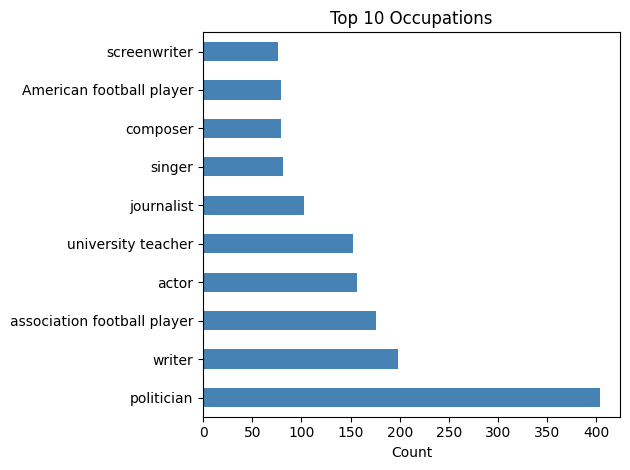


Top 10 Occupations:
politician                     404
writer                         198
association football player    176
actor                          157
university teacher             152
journalist                     103
singer                          81
composer                        79
American football player        79
screenwriter                    76
dtype: int64


In [54]:
# 2. Top occupations (from one-hot encoded columns)
occ_cols = [col for col in df.columns if col.startswith('occ_')]
if occ_cols:
    # Sum across all people to get total counts per occupation
    occ_counts = df[occ_cols].sum().sort_values(ascending=False).head(10)
    # Clean up column names (remove 'occ_' prefix)
    occ_counts.index = occ_counts.index.str.replace('occ_', '').str.replace('_', ' ')
    occ_counts.plot(kind='barh', title="Top 10 Occupations", color='steelblue')
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig('figures/02_top_occupations.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/02_top_occupations.png")
    plt.show()
    print(f"\nTop 10 Occupations:")
    print(occ_counts)
else:
    print("Occupation columns (occ_*) not found")


## 3. Awards vs Legend Status


Saved: figures/03_awards_vs_legend.png


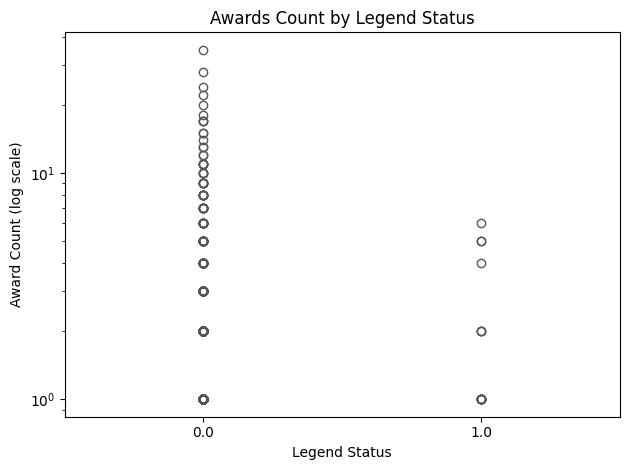

In [55]:
# 3. Awards vs Legend
if 'award_count' in df.columns:
    sns.boxplot(x='is_legend', y='award_count', data=df, palette=['#ff6b6b', '#51cf66'])
    plt.title("Awards Count by Legend Status")
    plt.yscale('log')
    plt.xlabel("Legend Status")
    plt.ylabel("Award Count (log scale)")
    plt.tight_layout()
    plt.savefig('figures/03_awards_vs_legend.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/03_awards_vs_legend.png")
    plt.show()
elif 'log_award_count' in df.columns:
    sns.boxplot(x='is_legend', y='log_award_count', data=df, palette=['#ff6b6b', '#51cf66'])
    plt.title("Log Awards Count by Legend Status")
    plt.xlabel("Legend Status")
    plt.ylabel("Log Award Count")
    plt.tight_layout()
    plt.savefig('figures/03_awards_vs_legend.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/03_awards_vs_legend.png")
    plt.show()
else:
    print("award_count column not found")
    print(f"Available columns: {[c for c in df.columns if 'award' in c.lower()]}")


## 4. Pre-Death Views vs Legend Status


Saved: figures/04_pre_death_views.png


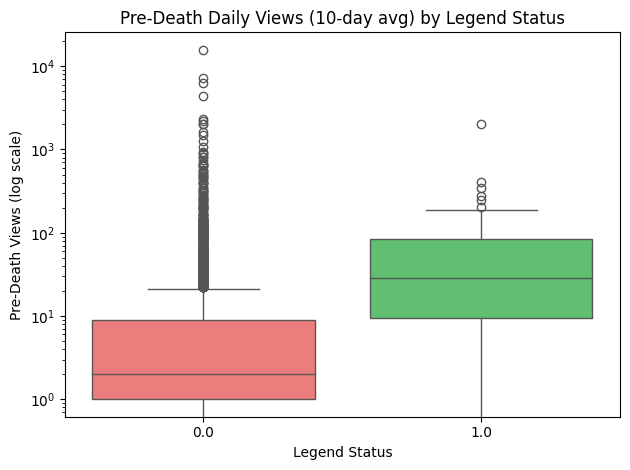

In [56]:
# 4. Pre-death views vs Legend
if 'avg_views_pre_death_10d' in df.columns:
    sns.boxplot(x='is_legend', y='avg_views_pre_death_10d', data=df, palette=['#ff6b6b', '#51cf66'])
    plt.title("Pre-Death Daily Views (10-day avg) by Legend Status")
    plt.yscale('log')
    plt.xlabel("Legend Status")
    plt.ylabel("Pre-Death Views (log scale)")
    plt.tight_layout()
    plt.savefig('figures/04_pre_death_views.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/04_pre_death_views.png")
    plt.show()
elif 'log_avg_views_pre_death_10d' in df.columns:
    sns.boxplot(x='is_legend', y='log_avg_views_pre_death_10d', data=df, palette=['#ff6b6b', '#51cf66'])
    plt.title("Log Pre-Death Views by Legend Status")
    plt.xlabel("Legend Status")
    plt.ylabel("Log Pre-Death Views")
    plt.tight_layout()
    plt.savefig('figures/04_pre_death_views.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/04_pre_death_views.png")
    plt.show()
else:
    print("avg_views_pre_death_10d column not found")
    print(f"Available columns: {[c for c in df.columns if 'view' in c.lower()][:5]}")


## 6. Final Dataset Assembly


In [57]:
# Additional analysis can go here
print("\nDataset Summary:")
print(f"Total samples: {len(df)}")
print(f"Legends (Y=1): {(df['is_legend'] == 1).sum()}")
print(f"Non-legends (Y=0): {(df['is_legend'] == 0).sum()}")
if 'is_legend' in df.columns:
    print(f"Legend rate: {df['is_legend'].mean():.1%}")



Dataset Summary:
Total samples: 2659
Legends (Y=1): 70
Non-legends (Y=0): 2589
Legend rate: 2.6%


## 7. Visualizations

### 7.1 Distribution of Sustained Ratio


Saved: figures/05_sustained_ratio_distribution.png


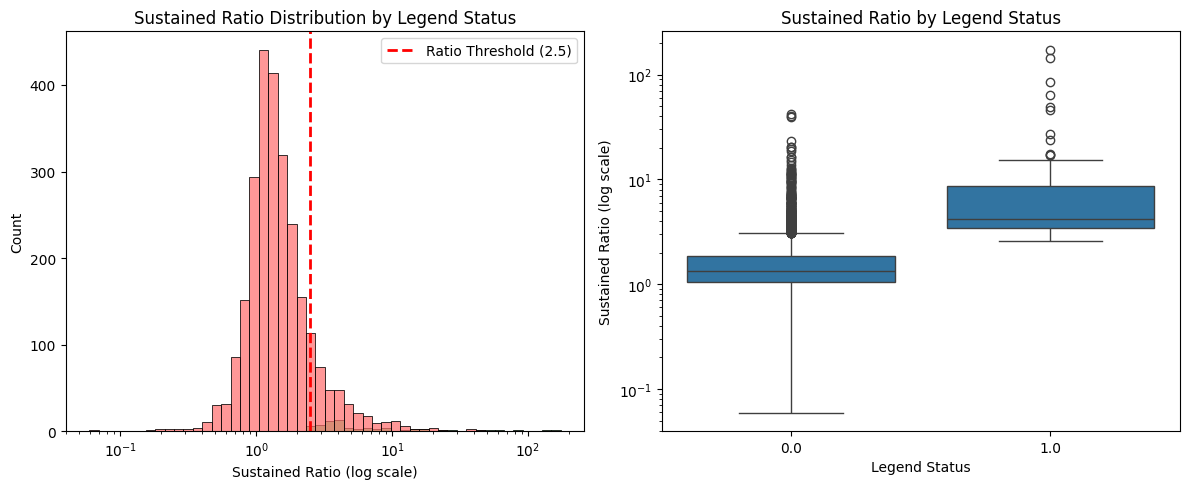

In [58]:
# Sustained ratio distribution (log scale) + threshold
plt.figure(figsize=(12, 5))

# Histogram with log scale
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='sustained_ratio_31_365', hue='is_legend', 
             log_scale=True, bins=50, alpha=0.7, palette=['#ff6b6b', '#51cf66'])
plt.axvline(2.5, color='red', linestyle='--', linewidth=2, label='Ratio Threshold (2.5)')
plt.xlabel("Sustained Ratio (log scale)")
plt.ylabel("Count")
plt.title("Sustained Ratio Distribution by Legend Status")
plt.legend()

# Box plot comparison
plt.subplot(1, 2, 2)
df_plot = df[df['sustained_ratio_31_365'].notna()].copy()
sns.boxplot(x='is_legend', y='sustained_ratio_31_365', data=df_plot)
plt.yscale('log')
plt.xlabel("Legend Status")
plt.ylabel("Sustained Ratio (log scale)")
plt.title("Sustained Ratio by Legend Status")

plt.tight_layout()
plt.savefig('figures/05_sustained_ratio_distribution.png', dpi=150, bbox_inches='tight')
print("Saved: figures/05_sustained_ratio_distribution.png")
plt.show()


### 7.2 Class Balance


Saved: figures/06_class_balance.png


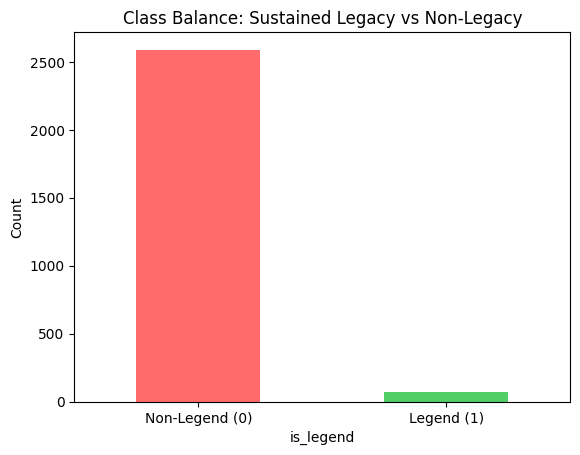

In [59]:
# Class balance
df['is_legend'].value_counts().plot(kind='bar', color=['#ff6b6b', '#51cf66'])
plt.xticks([0, 1], ['Non-Legend (0)', 'Legend (1)'], rotation=0)
plt.ylabel("Count")
plt.title("Class Balance: Sustained Legacy vs Non-Legacy")
plt.savefig('figures/06_class_balance.png', dpi=150, bbox_inches='tight')
print("Saved: figures/06_class_balance.png")
plt.show()


### 7.3 Pre-Death Popularity vs Sustained Legacy


Saved: figures/07_age_at_death.png


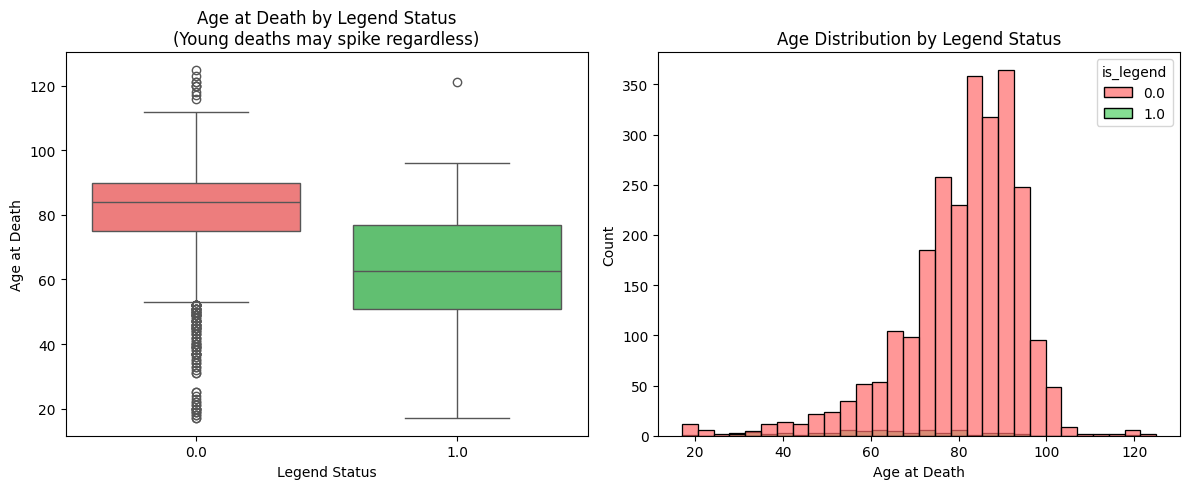

In [60]:
# Age at death vs legend (checking if young deaths are confounders)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_age = df[df['age_at_death'].notna()].copy()
sns.boxplot(x='is_legend', y='age_at_death', data=df_age, palette=['#ff6b6b', '#51cf66'])
plt.xlabel("Legend Status")
plt.ylabel("Age at Death")
plt.title("Age at Death by Legend Status\n(Young deaths may spike regardless)")

plt.subplot(1, 2, 2)
sns.histplot(data=df_age, x='age_at_death', hue='is_legend', bins=30, 
             alpha=0.7, palette=['#ff6b6b', '#51cf66'])
plt.xlabel("Age at Death")
plt.ylabel("Count")
plt.title("Age Distribution by Legend Status")

plt.tight_layout()
plt.savefig('figures/07_age_at_death.png', dpi=150, bbox_inches='tight')
print("Saved: figures/07_age_at_death.png")
plt.show()


### 7.4 Sitelinks vs Legacy Status


Saved: figures/08_sitelinks.png


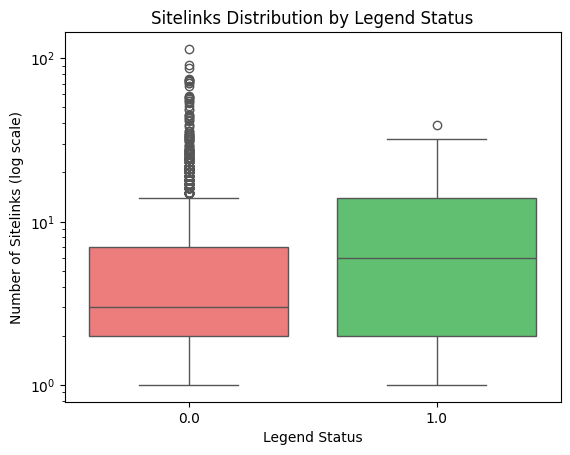

In [61]:
# Sitelinks vs Legend Status
df_sitelinks = df[df['sitelinks'].notna()].copy()
sns.boxplot(x='is_legend', y='sitelinks', data=df_sitelinks, palette=['#ff6b6b', '#51cf66'])
plt.yscale('log')
plt.xlabel('Legend Status')
plt.ylabel('Number of Sitelinks (log scale)')
plt.title('Sitelinks Distribution by Legend Status')
plt.savefig('figures/08_sitelinks.png', dpi=150, bbox_inches='tight')
print("Saved: figures/08_sitelinks.png")
plt.show()


### 7.5 Awards Count vs Legacy Status


Saved: figures/09_awards_count.png


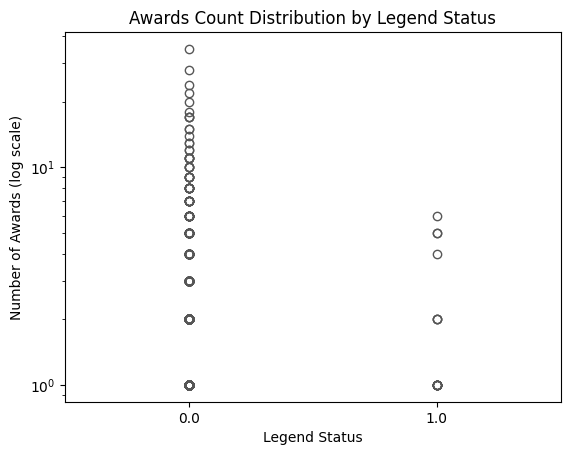

In [62]:
# Awards Count vs Legend Status
df_awards = df[df['award_count'].notna()].copy()
sns.boxplot(x='is_legend', y='award_count', data=df_awards, palette=['#ff6b6b', '#51cf66'])
plt.yscale('log')
plt.xlabel('Legend Status')
plt.ylabel('Number of Awards (log scale)')
plt.title('Awards Count Distribution by Legend Status')
plt.savefig('figures/09_awards_count.png', dpi=150, bbox_inches='tight')
print("Saved: figures/09_awards_count.png")
plt.show()


## 8. Summary Statistics


## Additional Visualizations


Saved: figures/10_fame_proxy.png


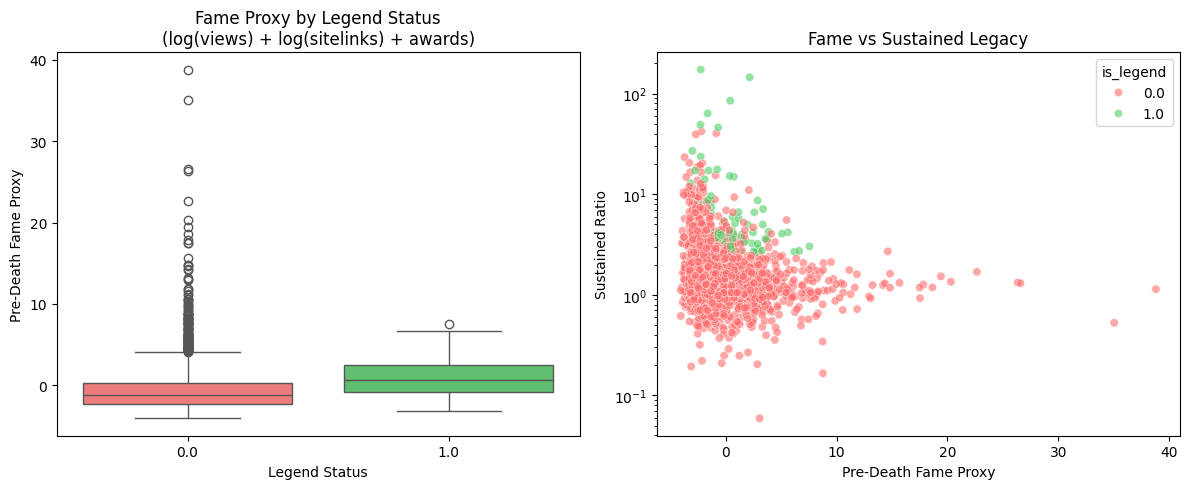

In [63]:
# Pre-death fame proxy vs legend status
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='is_legend', y='fame_proxy', data=df, palette=['#ff6b6b', '#51cf66'])
plt.xlabel("Legend Status")
plt.ylabel("Pre-Death Fame Proxy")
plt.title("Fame Proxy by Legend Status\n(log(views) + log(sitelinks) + awards)")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='fame_proxy', y='sustained_ratio_31_365', 
                hue='is_legend', alpha=0.6, palette=['#ff6b6b', '#51cf66'])
plt.xlabel("Pre-Death Fame Proxy")
plt.ylabel("Sustained Ratio")
plt.yscale('log')
plt.title("Fame vs Sustained Legacy")

plt.tight_layout()
plt.savefig('figures/10_fame_proxy.png', dpi=150, bbox_inches='tight')
print("Saved: figures/10_fame_proxy.png")
plt.show()


Saved: figures/11_year_distribution.png


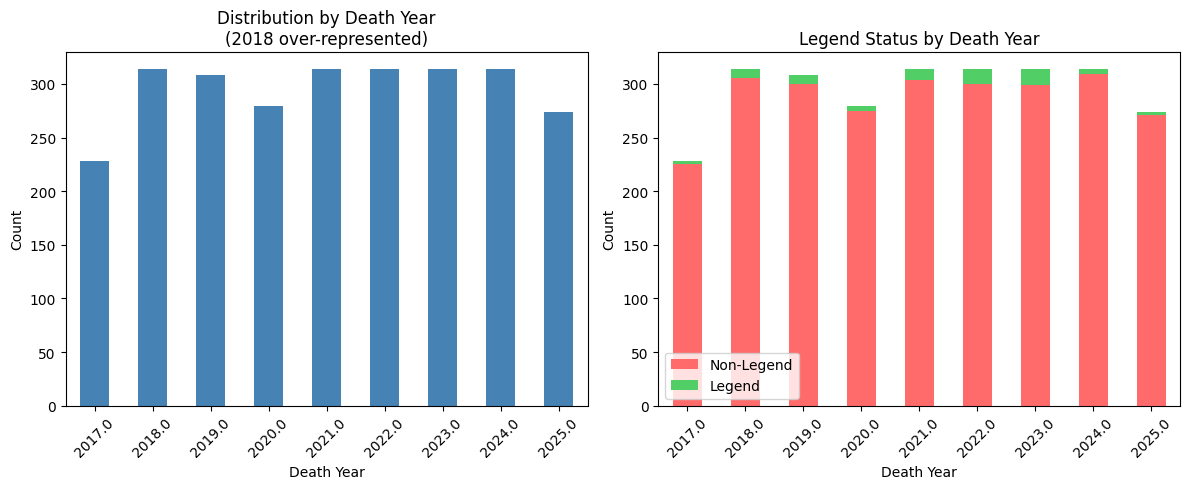


Year distribution:
death_year
2017.0    228
2018.0    314
2019.0    308
2020.0    279
2021.0    314
2022.0    314
2023.0    314
2024.0    314
2025.0    274
dtype: int64

2018 represents 11.8% of all deaths


In [64]:
# Year distribution (showing 2018 over-representation)
plt.figure(figsize=(12, 5))

year_counts = df.groupby('death_year').size()
year_legend = df.groupby(['death_year', 'is_legend']).size().unstack(fill_value=0)

plt.subplot(1, 2, 1)
year_counts.plot(kind='bar', color='steelblue')
plt.xlabel("Death Year")
plt.ylabel("Count")
plt.title("Distribution by Death Year\n(2018 over-represented)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
year_legend.plot(kind='bar', stacked=True, color=['#ff6b6b', '#51cf66'], ax=plt.gca())
plt.xlabel("Death Year")
plt.ylabel("Count")
plt.title("Legend Status by Death Year")
plt.xticks(rotation=45)
plt.legend(['Non-Legend', 'Legend'])

plt.tight_layout()
plt.savefig('figures/11_year_distribution.png', dpi=150, bbox_inches='tight')
print("Saved: figures/11_year_distribution.png")
plt.show()

print(f"\nYear distribution:")
print(year_counts)
print(f"\n2018 represents {year_counts[2018] / year_counts.sum() * 100:.1f}% of all deaths")


Saved: figures/12_occupations_comparison.png


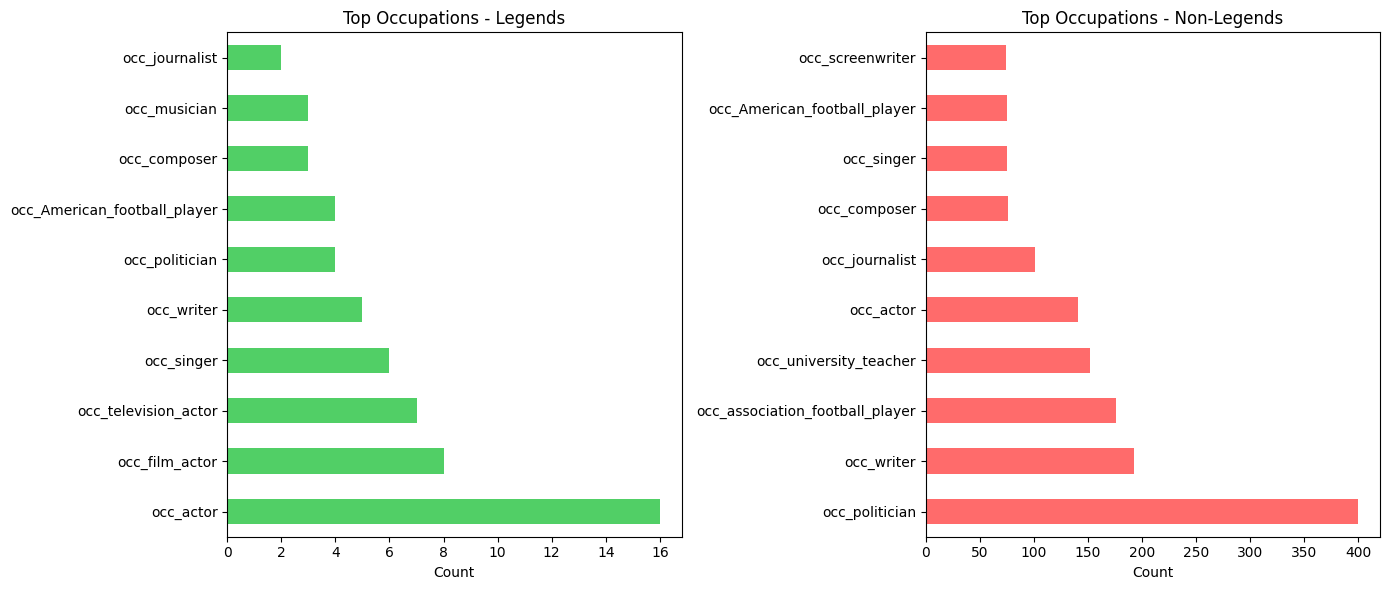

In [65]:
# Top occupations for legends vs non-legends
occ_cols = [col for col in df.columns if col.startswith('occ_')]
if occ_cols:
    legend_occ = df[df['is_legend'] == 1][occ_cols].sum().sort_values(ascending=False).head(10)
    non_legend_occ = df[df['is_legend'] == 0][occ_cols].sum().sort_values(ascending=False).head(10)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    legend_occ.plot(kind='barh', ax=axes[0], color='#51cf66')
    axes[0].set_title("Top Occupations - Legends")
    axes[0].set_xlabel("Count")
    
    non_legend_occ.plot(kind='barh', ax=axes[1], color='#ff6b6b')
    axes[1].set_title("Top Occupations - Non-Legends")
    axes[1].set_xlabel("Count")
    
    plt.tight_layout()
    plt.savefig('figures/12_occupations_comparison.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/12_occupations_comparison.png")
    plt.show()
else:
    print("Occupation columns not found")


Saved: figures/13_correlation_heatmap.png


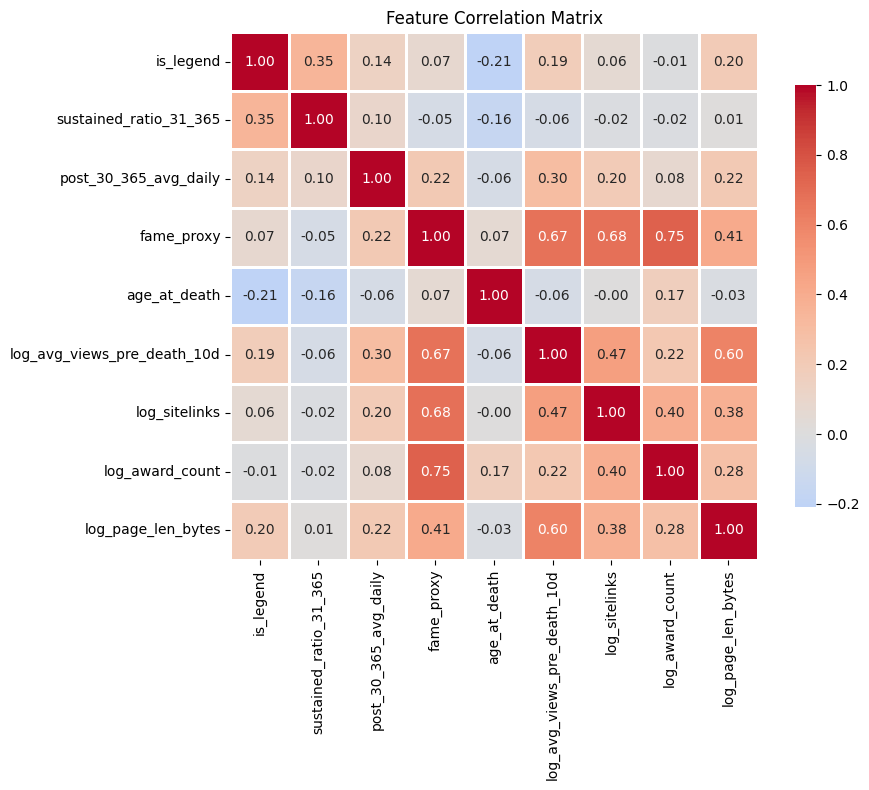

In [66]:
# Feature correlation heatmap (key features only)
key_features = [
    'is_legend', 'sustained_ratio_31_365', 'post_30_365_avg_daily',
    'fame_proxy', 'age_at_death', 'log_avg_views_pre_death_10d',
    'log_sitelinks', 'log_award_count', 'log_page_len_bytes'
]

available_features = [f for f in key_features if f in df.columns]
corr_matrix = df[available_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('figures/13_correlation_heatmap.png', dpi=150, bbox_inches='tight')
print("Saved: figures/13_correlation_heatmap.png")
plt.show()


In [69]:
# Final summary (already shown above in cell 24, but keeping for reference)
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Legends (Y=1): {(df['is_legend'] == 1).sum()}")
print(f"Non-legends (Y=0): {(df['is_legend'] == 0).sum()}")
print(f"Legend rate: {df['is_legend'].mean():.1%}")

print(f"\nTrain/Val Split:")
print(df['split'].value_counts())

print(f"\nMissing values (top 10):")
missing = df.isnull().sum().sort_values(ascending=False)
for col, count in missing[missing > 0].head(10).items():
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")



FINAL DATASET SUMMARY
Total samples: 2659
Legends (Y=1): 70
Non-legends (Y=0): 2589
Legend rate: 2.6%

Train/Val Split:
split
train    1757
val       902
Name: count, dtype: int64

Missing values (top 10):
  cause_of_death: 2351 (88.4%)
  birth_year: 7 (0.3%)
  age_at_death: 7 (0.3%)
  sitelinks: 1 (0.0%)
  award_count: 1 (0.0%)
